In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Feb 28 19:34:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%ls

%cd 'drive/MyDrive/Colab Notebooks/DivNet'

drive/  sample_data/
/content/drive/MyDrive/Colab Notebooks/DivNet


In [5]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import helperfunc as hf
import torch
import trainers as t
import Networks as n

!pip install ipython-autotime
%load_ext autotime

time: 185 µs (started: 2021-02-28 19:34:48 +00:00)


In [6]:
##load data
In = np.load('data/nn_output_10.npy')
out = np.load('data/nn_input_10.npy')
N,Dx = np.shape(In)
N,Dy =np.shape(out)

print('Input shape: ', np.shape(In))
print('Output shape: ',np.shape(out))

## Normalizing
for i in range(Dx):
    if np.min(In[:,i])<-200:
        new_data = (In[:,i]-np.mean(In[:,i]))/(np.std(In[:,i]))
        In[:,i]=new_data

Input shape:  (1000000, 24)
Output shape:  (1000000, 27)
time: 4.78 s (started: 2021-02-28 19:34:48 +00:00)


In [8]:
from sklearn.model_selection import train_test_split
In, X_test, out, y_test = train_test_split(In, out, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


time: 1.1 s (started: 2021-02-28 19:34:55 +00:00)


In [47]:
config_single ={
         "lr":1e-3,
         "epochs": 500,
         "batch_size": 32,
         "iters": 1000,#int(N/32),
         "input_dim" : Dx,
         "output_dim" : Dy,
         "hidden1" :700,
         "hidden2" :700,
         "display_interval":20,
         "print_it" : True,
    }


time: 2.65 ms (started: 2021-03-01 01:55:06 +00:00)


In [48]:
NNl, critl,mselosst,train_loss_s,val_loss=t.trainsingle(config_single,In,out,X_val,y_val)

print('Single Network Loss: ',mselosst)

starting training
iter :  0 	 train loss :0.774
iter :  20 	 train loss :0.011
iter :  40 	 train loss :0.019
iter :  60 	 train loss :0.004
iter :  80 	 train loss :0.003
iter :  100 	 train loss :0.004
iter :  120 	 train loss :0.002
iter :  140 	 train loss :0.002
iter :  160 	 train loss :0.006
iter :  180 	 train loss :0.002
iter :  200 	 train loss :0.002
iter :  220 	 train loss :0.001
iter :  240 	 train loss :0.001
iter :  260 	 train loss :0.008
iter :  280 	 train loss :0.003
iter :  300 	 train loss :0.002
iter :  320 	 train loss :0.001
iter :  340 	 train loss :0.001
iter :  360 	 train loss :0.003
iter :  380 	 train loss :0.002
iter :  400 	 train loss :0.001
iter :  420 	 train loss :0.006
iter :  440 	 train loss :0.005
iter :  460 	 train loss :0.002
iter :  480 	 train loss :0.002
Single Network Loss:  0.028287354856729507
time: 2min 29s (started: 2021-03-01 01:55:11 +00:00)


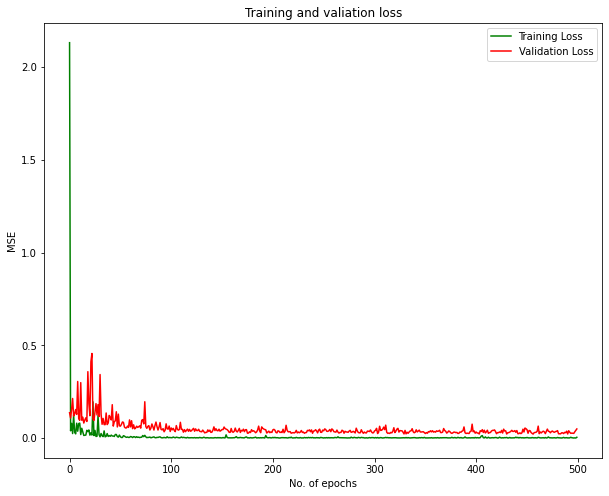

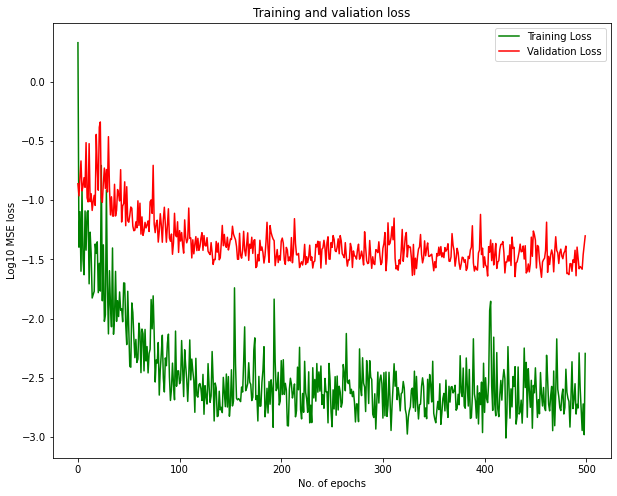

time: 877 ms (started: 2021-02-28 19:41:06 +00:00)


In [11]:
save=True
PATH="single_dict_model.pt"
if save:
  torch.save(NNl.state_dict(), PATH)
else:
  NNl = n.Large_NN(config_single)
  NNl.load_state_dict(torch.load(PATH))
  NNl.eval()

plt.figure(2,figsize=(10,8))
plt.plot(train_loss,'g-')
plt.plot(val_loss,'r-')
plt.title("Training and valiation loss")
plt.xlabel("No. of epochs")
plt.ylabel("MSE")
plt.legend(['Training Loss', 'Validation Loss'])

plt.figure(1,figsize=(10,8))
plt.plot(np.log10(train_loss),'g-')
plt.plot(np.log10(val_loss),'r-')
plt.title("Training and valiation loss")
plt.xlabel("No. of epochs")
plt.ylabel("Log10 MSE loss")
plt.legend(['Training Loss', 'Validation Loss'])

In [13]:
#cor = hf.corr(In,out,Dx,Dy)

#print(np.argmin(cor))
config_section ={
        "init_select":4,
        "runs":50,
         "lr":1e-3,
         "epochs": 50,
         "batch_size": 32,
         "iters": 100,#int(N/32),
         "input_dim" : Dx,
         "output_dim" : Dy,
         "hidden1" :80,
         "hidden2" :80,
         "display_interval":30,
         "print_it" : True,
         "c":50,
         "ref_s": 7,#int(np.ceil(Dx/Dy)),
         "ref_v":np.var(In),
         "phi_1":1.0,
         "phi_2":1e-2,
         "phi_3":1e-5,
         "beta":0.5,
         "dim":6#np.argmin(cor) #fixed value to avaoid calculating correlation every time
    }

time: 101 ms (started: 2021-02-28 19:41:39 +00:00)


In [14]:
SN = config_section["init_select"]
iters = config_section["runs"]
dim = config_section["dim"]

l=np.zeros((iters,4))

sns=np.zeros(iters)
on,bn = hf.init_s(SN,dim,In)
dmse = np.zeros(iters)
ds = np.zeros(iters)
dv = np.zeros(iters)

mse_best=10000
best_config={}

for i in range(iters):
    NN, crit,all_in,all_out,lossind,train_loss,test_loss = t.trainsect(config_section, In, out,SN,on,bn,X_val,y_val)
    if mse_best >=np.mean(lossind):
        mse_best=np.mean(lossind)
        best_config['NN']=NN
        best_config['o']=on
        best_config['b']=bn
        best_config['sn']=SN
        best_config['crit']=crit
        best_config['all_in']=all_in
        best_config['all_out']=all_out
    l[i,:]=hf.loss_1(all_in,all_out,SN,bn,on,config_section,NN,lossind,mselosst)
    
    bold,bnew,dmse[i],dv[i],ds[i] =hf.update_b(In,all_in,all_out,bn,on,SN,NN,config_section,lossind,mselosst,thresh=0.2)
    
    SN,bn,on =hf.gen_s_b_o(bold,bnew,on,config_section,In)

    print('run: ',i,' Sn: ',SN,' bnew: ',bn, 'bold: ',bold, '\n \t LOSS2: ',np.mean(lossind),'\n mse:',l[i,1],'varloss:',l[i,2],'sloss:',l[i,3])
    sns[i]=SN
    

sorting data for section:  0
starting training for section:  0


/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1+ np.exp(slope*(data-(offset+band))))


iter :  0 	 train loss :6.861
iter :  30 	 train loss :0.013
data points for section:0 are:  1542
sorting data for section:  1
starting training for section:  1
iter :  0 	 train loss :0.414
iter :  30 	 train loss :0.011
data points for section:1 are:  528995
sorting data for section:  2
starting training for section:  2
iter :  0 	 train loss :0.811
iter :  30 	 train loss :0.013
data points for section:2 are:  166021
sorting data for section:  3
starting training for section:  3


/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1+ np.exp(slope*(-data+offset)))


iter :  0 	 train loss :9.741
iter :  30 	 train loss :0.013
data points for section:3 are:  3442
run:  0  Sn:  6  bnew:  [5.37753657 0.2        5.29406143 5.68357134 4.13879233 0.94339765] bold:  [5.40933983 5.40933983 5.40933983 5.40933983] 
 	 LOSS2:  0.024700379697605968 
 mse: 0.012292947387322783 varloss: 620.0098985260356 sloss: 0.5596157879354228
sorting data for section:  0
starting training for section:  0
iter :  0 	 train loss :7.223
iter :  30 	 train loss :0.012
data points for section:0 are:  1515
sorting data for section:  1
starting training for section:  1
iter :  0 	 train loss :4.291
iter :  30 	 train loss :0.011
data points for section:1 are:  177
sorting data for section:  2
starting training for section:  2
iter :  0 	 train loss :0.542
iter :  30 	 train loss :0.045
data points for section:2 are:  543510
sorting data for section:  3
starting training for section:  3
iter :  0 	 train loss :0.575
iter :  30 	 train loss :0.013
data points for section:3 are:  151

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:71: RuntimeWarning: invalid value encountered in true_divide
  MSE = np.sum((out-y3r)**2,0)/N


run:  18  Sn:  9  bnew:  [5.78001755 0.2        0.2        4.16533728 3.14788891 1.79280952
 3.21520243 1.08465288 2.57070711] bold:  [5.7610457  0.20416002 0.2        4.11350495 2.93680553 1.74895424
 3.18740721 1.04268596 2.50051608 0.45108737] 
 	 LOSS2:  nan 
 mse: nan varloss: nan sloss: 0.3566749439387324
sorting data for section:  0
starting training for section:  0
iter :  0 	 train loss :9.909
iter :  30 	 train loss :0.018
data points for section:0 are:  1872
sorting data for section:  1
starting training for section:  1
iter :  0 	 train loss :5.049
iter :  30 	 train loss :0.009
data points for section:1 are:  239
sorting data for section:  2
starting training for section:  2
iter :  0 	 train loss :7.905
iter :  30 	 train loss :0.011
data points for section:2 are:  255
sorting data for section:  3
starting training for section:  3
iter :  0 	 train loss :1.031
iter :  30 	 train loss :0.007
data points for section:3 are:  57463
sorting data for section:  4
starting traini

In [15]:
print('dmse',dmse)
print('dv',dv)
print('ds',ds)

dmse [-1.92606941e+04 -9.65053470e+03  1.72120785e+04 -7.35377681e+03
  1.82714842e+04  1.87495894e+04 -8.01115955e+03  1.81571609e+04
  7.10653693e+03  5.34874682e+03  1.27526327e+03 -2.48814583e+04
  1.18211938e+04  2.95653404e+04 -2.30544448e+04 -6.09371377e+03
 -1.40456303e+04 -7.10033102e+03  0.00000000e+00  1.34043615e+03
  5.90204155e+02 -3.12033460e+00 -2.90298567e+02 -1.53132684e+04
 -4.26678781e+03  5.17636225e+03 -3.20685256e+03  7.80006391e+01
  4.12985964e+02  7.70993800e+03 -1.91641987e+04 -7.01771219e+01
  0.00000000e+00 -1.82493193e+02 -2.10224524e+03 -2.28959863e+01
  2.56072183e+02 -6.42859051e+03  8.66119912e+03 -1.37269866e+04
  2.85399922e+03 -7.34206074e+02  4.12563297e+04  1.22667676e+04
 -4.14340805e+02  3.03998634e+03 -9.24880332e+04 -2.45324375e+04
  8.73835515e+02  9.93779663e+01]
dv [-0.45051953 -0.11913273 -0.38533162 -0.12396123 -0.12396123 -0.11440359
 -0.10317972 -0.0678402  -0.52525556 -0.26912639 -0.25619664 -0.25686673
 -0.25950787 -0.26849401 -0.1239

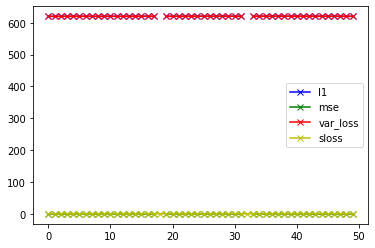

time: 530 ms (started: 2021-02-28 21:33:49 +00:00)


In [16]:
#### saving best model and plotting progress

plt.plot(l[:,0],'b-x')
plt.plot(l[:,1],'g-x')
plt.plot(l[:,2],'r-x')
plt.plot(l[:,3],'y-x')
plt.legend(['l1', 'mse', 'var_loss','sloss'])


NN=best_config['NN']
on=best_config['o']
bn=best_config['b']
SN=best_config['sn']
crit=best_config['crit']
all_in=best_config['all_in']
all_out=best_config['all_out']

for i in range(SN):
    PATH="section_dict_model"+str(i)+".pt"
    torch.save(NN[str(i)].state_dict(), PATH)


In [17]:
config_section ={
        "init_select":4,
        "runs":50,
         "lr":1e-3,
         "epochs": 500,
         "batch_size": 32,
         "iters": 1000,#int(N/32),
         "input_dim" : Dx,
         "output_dim" : Dy,
         "hidden1" :80,
         "hidden2" :80,
         "display_interval":30,
         "print_it" : True,
         "c":50,
         "ref_s": 7,#int(np.ceil(Dx/Dy)),
         "ref_v":np.var(In),
         "phi_1":1.0,
         "phi_2":1e-2,
         "phi_3":1e-5,
         "beta":0.5,
         "dim":6#np.argmin(cor) #fixed value to avaoid calculating correlation every time
}
NN, crit,all_in,all_out,lossind,train_loss,test_loss = t.trainsect(config_section, In, out,SN,on,bn,X_val,y_val)

sorting data for section:  0
starting training for section:  0


/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1+ np.exp(slope*(data-(offset+band))))


iter :  0 	 train loss :1.681
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.001
iter :  90 	 train loss :0.001
iter :  120 	 train loss :0.001
iter :  150 	 train loss :0.002
iter :  180 	 train loss :0.001
iter :  210 	 train loss :0.001
iter :  240 	 train loss :0.001
iter :  270 	 train loss :0.001
iter :  300 	 train loss :0.001
iter :  330 	 train loss :0.001
iter :  360 	 train loss :0.001
iter :  390 	 train loss :0.001
iter :  420 	 train loss :0.001
iter :  450 	 train loss :0.001
iter :  480 	 train loss :0.001
data points for section:0 are:  2565
sorting data for section:  1
starting training for section:  1
iter :  0 	 train loss :0.144
iter :  30 	 train loss :0.001
iter :  60 	 train loss :0.001
iter :  90 	 train loss :0.001
iter :  120 	 train loss :0.001
iter :  150 	 train loss :0.001
iter :  180 	 train loss :0.001
iter :  210 	 train loss :0.001
iter :  240 	 train loss :0.001
iter :  270 	 train loss :0.001
iter :  300 	 train loss :0.001
iter :  330 	 

/content/drive/MyDrive/Colab Notebooks/DivNet/helperfunc.py:9: RuntimeWarning: overflow encountered in exp
  return 1/(1+ np.exp(slope*(-data+offset)))


iter :  0 	 train loss :0.749
iter :  30 	 train loss :0.002
iter :  60 	 train loss :0.001
iter :  90 	 train loss :0.001
iter :  120 	 train loss :0.001
iter :  150 	 train loss :0.001
iter :  180 	 train loss :0.002
iter :  210 	 train loss :0.002
iter :  240 	 train loss :0.001
iter :  270 	 train loss :0.001
iter :  300 	 train loss :0.002
iter :  330 	 train loss :0.001
iter :  360 	 train loss :0.001
iter :  390 	 train loss :0.002
iter :  420 	 train loss :0.002
iter :  450 	 train loss :0.002
iter :  480 	 train loss :0.001
data points for section:7 are:  1117
sorting data for section:  8
starting training for section:  8
iter :  0 	 train loss :0.743
iter :  30 	 train loss :0.001
iter :  60 	 train loss :0.001
iter :  90 	 train loss :0.001
iter :  120 	 train loss :0.001
iter :  150 	 train loss :0.001
iter :  180 	 train loss :0.001
iter :  210 	 train loss :0.001
iter :  240 	 train loss :0.001
iter :  270 	 train loss :0.001
iter :  300 	 train loss :0.001
iter :  330 	 

In [18]:
print(SN, bn)

11 [6.34286704 0.23964128 0.26071272 2.37507546 0.2        3.9461646
 3.70874378 1.64065842 0.83138549 1.52840088 0.56370966]
time: 2.92 ms (started: 2021-03-01 01:17:05 +00:00)


In [87]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
#with open('params.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([SN, bn, on], f)

# Getting back the objects:
#with open('params.pkl','rb') as f:  # Python 3: open(..., 'rb') 
#    SN, bn, on = pickle.load(f)


[11, array([6.34286704, 0.23964128, 0.26071272, 2.37507546, 0.2       ,
       3.9461646 , 3.70874378, 1.64065842, 0.83138549, 1.52840088,
       0.56370966]), array([  0.        , -10.90168889,  -4.55882185,  -4.31918058,
        -4.05846786,  -1.6833924 ,  -1.4833924 ,   2.4627722 ,
         6.17151598,   7.8121744 ,   8.64355989,  10.17196077])]
time: 9.38 ms (started: 2021-03-01 03:02:36 +00:00)


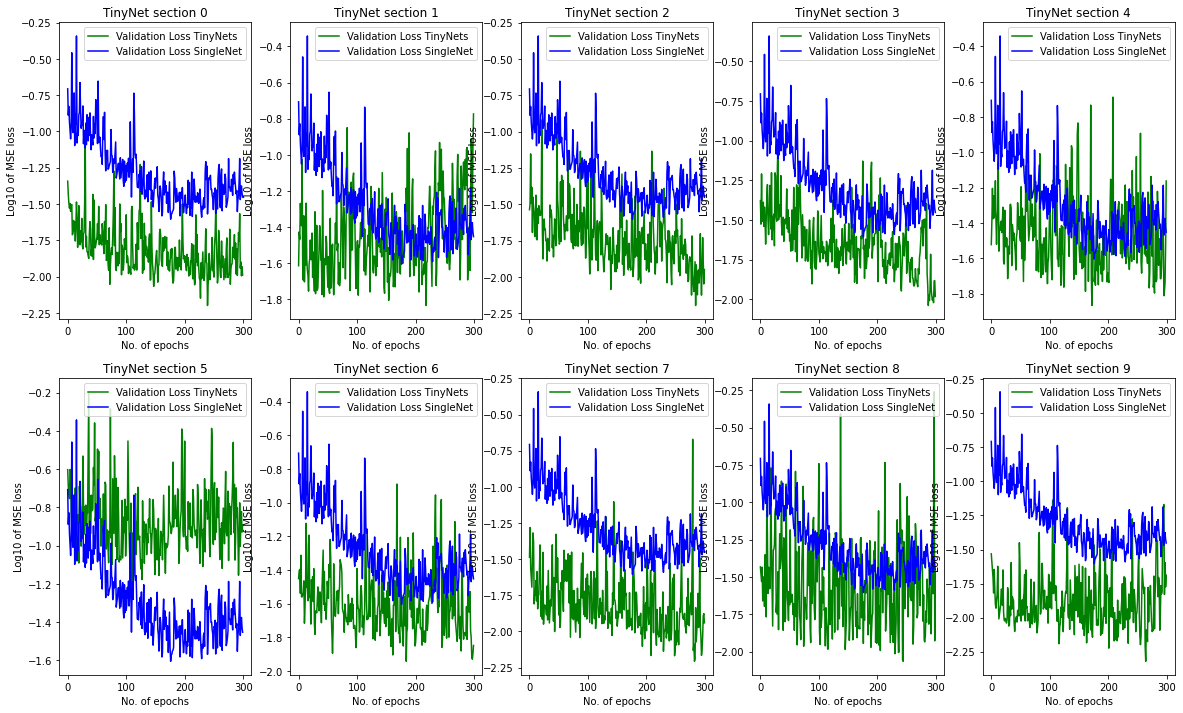

time: 2.04 s (started: 2021-03-01 02:33:46 +00:00)


In [61]:
fig, axs = plt.subplots(2, 5, figsize=(20,12))

for i in range(SN-1):
  if i<5:
    #axs[0,i].plot(train_loss[str(i)][0:300],'r-')
    axs[0,i].plot(np.log10(test_loss[str(i)][0:300]),'g-')
    axs[0,i].plot(np.log10(val_loss[0:300]),'b-')
    axs[0,i].set_title("TinyNet section "+str(i))
    axs[0,i].set_xlabel("No. of epochs")
    axs[0,i].set_ylabel("Log10 of MSE loss")
    axs[0,i].legend(['Validation Loss TinyNets', 'Validation Loss SingleNet'])
    
  else:
    #axs[0,i].plot(train_loss[str(i)][0:300],'r-')
    axs[1,i-5].plot(np.log10(test_loss[str(i)][0:300]),'g-')
    axs[1,i-5].plot(np.log10(val_loss[0:300]),'b-')
    axs[1,i-5].set_title("TinyNet section "+str(i))
    axs[1,i-5].set_xlabel("No. of epochs")
    axs[1,i-5].set_ylabel("Log10 of MSE loss")
    axs[1,i-5].legend(['Validation Loss TinyNets', 'Validation Loss SingleNet'])
  

Text(0, 0.5, 'log10 of MSE loss')

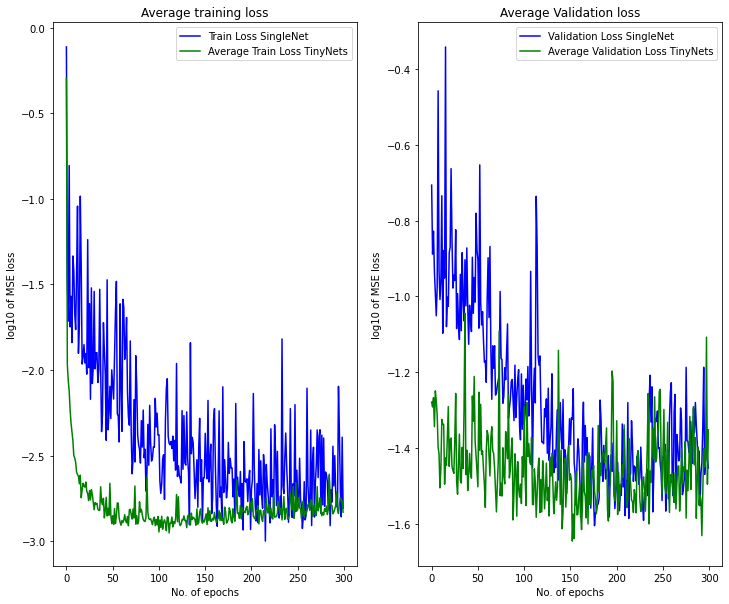

time: 531 ms (started: 2021-03-01 02:49:17 +00:00)


In [80]:
tlossav_tiny = np.zeros(300)
vlossav_tiny = np.zeros(300)
for i in range(SN):

    tlossav_tiny += train_loss[str(i)][0:300]
    vlossav_tiny += test_loss[str(i)][0:300]

tlossav_tiny /= SN
vlossav_tiny /= SN 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,10)) 
ax1.plot(np.log10(train_loss_s[0:300]),'b-')  
ax1.plot(np.log10(tlossav_tiny),'g-')
ax2.plot(np.log10(val_loss[0:300]),'b-')  
ax2.plot(np.log10(vlossav_tiny),'g-')
ax1.set_title("Average training loss")
ax1.set_xlabel("No. of epochs")
ax1.set_ylabel("log10 of MSE loss")
ax1.legend(['Train Loss SingleNet', 'Average Train Loss TinyNets'])
ax2.legend(['Validation Loss SingleNet','Average Validation Loss TinyNets'])

ax2.set_title("Average Validation loss")
ax2.set_xlabel("No. of epochs")
ax2.set_ylabel("log10 of MSE loss")

In [19]:
for i in range(SN):
    PATH="section_dict_model"+str(i)+".pt"
    torch.save(NN[str(i)].state_dict(), PATH)


time: 61.7 ms (started: 2021-03-01 01:17:05 +00:00)


In [ ]:
config_tiny ={
        "input_dim":1,
        "output_dim":1,
        "hidden1":2,
        "hidden2":2,
        "lr":1e-3,
        "epochs": 200,
        "batch_size": 500,
        "iters": 100,#int(N/500),
        "display_interval":10,
        "print_it":True,
        "dim":config_section["dim"]
}
dim = config_tiny["dim"]
data,labels= hf.generate_rdata(SN,on,bn,In,dim)
val_data,val_labels =hf.generate_rdata(SN,on,bn,X_val,dim)
test_data,test_labels =hf.generate_rdata(SN,on,bn,X_test,dim)

NNt, criteriont,train_loss,val_loss=t.traintiny(config_tiny, data,labels,val_data,val_labels)


In [ ]:
PATH="tiny_dict_model.pt"
torch.save(NNt.state_dict(), PATH)

In [ ]:
NNt.eval()
test_data = torch.tensor(test_data, dtype=torch.float) #  tensor
outputs = NNt(test_data)
outs=np.round(outputs.detach().numpy())
tot=np.abs(outs-test_labels)
tot= np.sum(tot)
print('Incorrect labels', tot)

In [ ]:
import torch.nn as nn
def test(NNt,NN,X_test, y_test,SN,dim,on,bn):
    criterion = nn.MSELoss()
    NNt.eval()
    N,D = np.shape(X_test)
    data =np.reshape(X_test[:,dim],(N,1))
    data = torch.tensor(data, dtype=torch.float)
    X_test = torch.tensor(X_test, dtype=torch.float,requires_grad=True)
    y_test = torch.tensor(y_test, dtype=torch.float) #  tensor
    selectors = NNt(data).detach().numpy()
    loss = 0 
    print('calculating loss')
    for i in range(N):
        j = int(selectors[i])
        NN[str(j)].eval()
        ypred=NN[str(j)](X_test[i])
        loss += criterion(ypred, y_test[i]).item()
        #ypred[i]=NN[str(j)](torch.tensor(X_test[i], dtype=torch.float)).detach().numpy()
    #ypred = torch.tensor(ypred, dtype=torch.float) #  tensor
    
    return loss/N

In [ ]:
Nt,Dt = np.shape(X_test)

In [ ]:
dim = config_tiny["dim"]

loss = test(NNt,NN,X_test,y_test,SN,dim,on,bn)
print('test loss =', loss)

In [ ]:
print('time per data point:',74000/Nt)

In [ ]:
dim = config_tiny["dim"]
loss = test(NNt,NN,In,out,SN,dim,on,bn)
print('train loss =', loss)

In [ ]:
Nt,Dt = np.shape(In)

print('time per data point:',156000/Nt)

In [ ]:
import torch.nn as nn
def testl(NNl,X_test, y_test):
    criterion = nn.MSELoss()
    N,D = np.shape(X_test)

    X_test = torch.tensor(X_test, dtype=torch.float,requires_grad=True)
    y_test = torch.tensor(y_test, dtype=torch.float) #  tensor
    loss = 0 
    print('calculating loss')
    NNl.eval
    for i in range(N):
        NNl.eval()
        ypred=NNl(X_test[i])
        loss += criterion(ypred, y_test[i]).item()
        #ypred[i]=NN[str(j)](torch.tensor(X_test[i], dtype=torch.float)).detach().numpy()
    #ypred = torch.tensor(ypred, dtype=torch.float) #  tensor
    
    return loss/N

In [ ]:
dim = config_tiny["dim"]

loss = testl(NNl,X_test,y_test)
print('test loss =', loss)

In [ ]:
Nt,Dt = np.shape(X_test)

print('time per data point:',79000/Nt)

In [ ]:
dim = config_tiny["dim"]
loss = testl(NNl,In,out)
print('train loss =', loss)

In [ ]:
Nt,Dt = np.shape(In)

print('time per data point:',155000/Nt)